In [10]:
# Import Block
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.tools as tls
import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go 
from collections import Counter 
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots
from sklearn import preprocessing

In [40]:
df = pd.read_csv("../data/raw/german_credit_data.csv", index_col=0)

In [41]:

# Display Max columns
pd.pandas.set_option("display.max_columns", None)

# enable offline plotly version
py.init_notebook_mode(connected=True) 

# Dark Mode of Ploty
pio.templates.default = "plotly_dark"

# Dark Mode
sns.set_theme(
    style='dark',
    rc={
        'figure.facecolor': 'black',
        'axes.facecolor':   'black',
        'axes.edgecolor':   'white',
        'savefig.facecolor':'black',
        'text.color':       'white',
        'axes.labelcolor':  'white',
        'xtick.color':      'white',
        'ytick.color':      'white' 
    }
)

plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor':   'black',
    'axes.edgecolor':   'white',
    'savefig.facecolor':'black',
    'text.color':       'white',
    'axes.labelcolor':  'white',
    'xtick.color':      'white',
    'ytick.color':      'white',
    'grid.color':       'gray',
})

In [42]:
# ------------------------------------------------------------
# 1. Data Overview
#    Provide a dimensional understanding of the dataset
# ------------------------------------------------------------
print("_" * 120)
print(f"DIMENSIONS OF DATASET: {df.shape}")  # rows and columns
print("_" * 120)


# ------------------------------------------------------------
# 2. Feature Information
#    Display data types and non-null counts for each column
# ------------------------------------------------------------
print("FEATURE INFO:")
df.info()
print("_" * 120)


# ------------------------------------------------------------
# 3. Unique Value Counts
#    Show number of distinct entries per column
# ------------------------------------------------------------
print("UNIQUE VALUE COUNTS:")
print(df.nunique())
print("_" * 120)


# ------------------------------------------------------------
# 4. Basic Statistical Summary
#    Summary of numeric columns (mean, std, min, max, etc.)
# ------------------------------------------------------------
print("BASIC STATISTICS:")
print(df.describe())
print("_" * 120)


# ------------------------------------------------------------
# 5. Categorical Value Counts
#    Frequency counts for all object-dtype (categorical) columns
# ------------------------------------------------------------
print("CATEGORICAL VALUE COUNTS:")
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
for col in cat_cols:
    print(f"\n-- {col} --")
    print(df[col].value_counts())
print("_" * 120)


# ------------------------------------------------------------
# 6. Sample of Data
#    Preview the first few rows of the dataset
# ------------------------------------------------------------
print("DATA PREVIEW:")
print(df.head())
print("_" * 120)


________________________________________________________________________________________________________________________
DIMENSIONS OF DATASET: (1000, 10)
________________________________________________________________________________________________________________________
FEATURE INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
______

In [43]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

In [44]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na
##################################################################################################################
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)

        # Fix: apply .any() directly on the boolean Series
        if ((dataframe[col] > up_limit) | (dataframe[col] < low_limit)).any():
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(f"{col} : {number_of_outliers}")
            variable_names.append(col)

            if plot:
                sns.boxplot(x=dataframe[col])
                plt.title(f'Boxplot for {col}')
                plt.show()

    return variable_names
##################################################################################################################
def rare_analyser(dataframe, categorical_columns, target, rare_perc):
    rare_columns = [col for col in categorical_columns
                    if (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]
    for var in rare_columns:
        print(var, " : ", len(dataframe[var].value_counts()))

        print(pd.DataFrame({"COUNT": dataframe[var].value_counts(),
                            "RATIO": dataframe[var].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(var)[target].mean(),
                            "TARGET_MEDIAN": dataframe.groupby(var)[target].median()}),
              end="\n\n\n")

    print("There are",len(rare_columns), "variables with rare classes.")
##################################################################################################################
def label_encoder(dataframe, categorical_columns):
    labelencoder = preprocessing.LabelEncoder()
    for col in categorical_columns:
        if dataframe[col].nunique() == 2:
            dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe
##################################################################################################################
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

## PreProcessing

In [45]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Id"]
print(num_cols,"\n")
print('Number of Numerical Variable: ', len(num_cols))

['Age', 'Job', 'Credit amount', 'Duration', 'Age_cat'] 

Number of Numerical Variable:  5


In [46]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']
print(cat_cols,"\n")
print('Number of Categoric Variable: ', len(cat_cols))

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk'] 

Number of Categoric Variable:  6


## 2.1. Missing Value Analysis

In [47]:
missing_values_table(df)

                  n_miss  ratio
Checking account     394   39.4
Saving accounts      183   18.3


['Saving accounts', 'Checking account']

<Axes: >

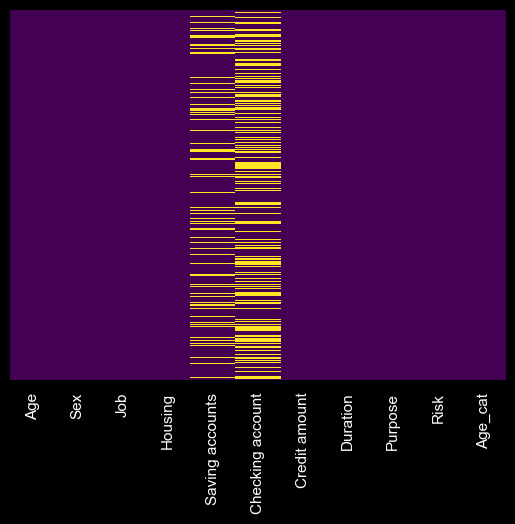

In [48]:
# Heatmap of dataframe's missing value mask
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [49]:
# Define intervals and labels
interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']

# Create age category column
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

# Fill missing 'Saving accounts' values using mode within group
df["Saving accounts"] = df.groupby(
    ["Sex", "Risk", "Age_cat"], observed=True
)["Saving accounts"].transform(lambda x: x.fillna(x.mode()[0]))

# Fill missing 'Checking account' values similarly
df["Checking account"] = df.groupby(
    ["Sex", "Risk", "Age_cat"], observed=True
)["Checking account"].transform(lambda x: x.fillna(x.mode()[0]))

In [50]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

## 2.2. Outlies Analysis

In [51]:
has_outliers(df, ["Age", "Credit amount", "Duration"])

[]

## 2.3. Rare Analysis

In [52]:
label_columns = ["Sex", "Risk"]
label_encoder(df, label_columns)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,1,2,own,little,little,1169,6,radio/TV,1,Senior
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,Student
2,49,1,1,own,little,little,2096,12,education,1,Adult
3,45,1,2,free,little,little,7882,42,furniture/equipment,1,Adult
4,53,1,2,free,little,little,4870,24,car,0,Adult
...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,own,little,little,1736,12,furniture/equipment,1,Young
996,40,1,3,own,little,little,3857,30,car,1,Adult
997,38,1,2,own,little,little,804,12,radio/TV,1,Adult
998,23,1,2,free,little,little,1845,45,radio/TV,0,Student


In [53]:
temp_cat = ["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Duration", "Purpose"]
rare_analyser(df, temp_cat, "Risk", 0.5)

Sex  :  2
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Sex                                          
0      310   0.31     0.648387            1.0
1      690   0.69     0.723188            1.0


Job  :  4
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Job                                          
0       22  0.022     0.681818            1.0
1      200  0.200     0.720000            1.0
2      630  0.630     0.704762            1.0
3      148  0.148     0.655405            1.0


Housing  :  3
         COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Housing                                          
free       108  0.108     0.592593            1.0
own        713  0.713     0.739130            1.0
rent       179  0.179     0.608939            1.0


Saving accounts  :  4
                 COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Saving accounts                                          
little             786  0.786     0.683206            1.0
moderate           103  0.103     0.669903            

In [54]:
df.loc[df["Duration"] == 5, ["Duration"]] = 4
df.loc[df["Duration"] == 7, ["Duration"]] = 4
df.loc[df["Duration"] == 11, ["Duration"]] = 4

df.loc[df["Duration"] == 8, ["Duration"]] = 6
df.loc[df["Duration"] == 10, ["Duration"]] = 6

df.loc[df["Duration"] == 12, ["Duration"]] = 9

df.loc[df["Duration"] == 24, ["Duration"]] = 21

df.loc[df["Duration"] == 28, ["Duration"]] = 27
df.loc[df["Duration"] == 30, ["Duration"]] = 27
df.loc[df["Duration"] == 33, ["Duration"]] = 27

df.loc[df["Duration"] == 42, ["Duration"]] = 39

df.loc[df["Purpose"] == "domestic appliances", ["Purpose"]] = "furniture/equipment"

rare_analyser(df, temp_cat, "Risk", 0.5)

Sex  :  2
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Sex                                          
0      310   0.31     0.648387            1.0
1      690   0.69     0.723188            1.0


Job  :  4
     COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Job                                          
0       22  0.022     0.681818            1.0
1      200  0.200     0.720000            1.0
2      630  0.630     0.704762            1.0
3      148  0.148     0.655405            1.0


Housing  :  3
         COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Housing                                          
free       108  0.108     0.592593            1.0
own        713  0.713     0.739130            1.0
rent       179  0.179     0.608939            1.0


Saving accounts  :  4
                 COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
Saving accounts                                          
little             786  0.786     0.683206            1.0
moderate           103  0.103     0.669903            

# 3.Feature Engineering

In [55]:
# Deriving Year variable from Duration variable.
# Thus, it will be understood how many years of customers there are.
df["Year"] = str(df["Duration"])
df.loc[df["Duration"] <= 12, "Year"] = "0-1 year"
df.loc[(df["Duration"] > 12) & (df["Duration"] <= 24), "Year"] = "1-2 year"
df.loc[(df["Duration"] > 24) & (df["Duration"] <= 36), "Year"] = "2-3 year"
df.loc[(df["Duration"] > 36) & (df["Duration"] <= 48), "Year"] = "3-4 year"
df.loc[(df["Duration"] > 48) & (df["Duration"] <= 60), "Year"] = "4-5 year"
df.loc[(df["Duration"] > 60) & (df["Duration"] <= 72), "Year"] = "5-6 year"
df.loc[(df["Duration"] > 72) & (df["Duration"] <= 84), "Year"] = "6-7 year"

df["Status"] = pd.qcut(df["Credit amount"], 4, labels=["poor", "mid", "upper", "rich"])
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat,Year,Status
0,67,1,2,own,little,little,1169,6,radio/TV,1,Senior,0-1 year,poor
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,Student,3-4 year,rich
2,49,1,1,own,little,little,2096,9,education,1,Adult,0-1 year,mid
3,45,1,2,free,little,little,7882,39,furniture/equipment,1,Adult,3-4 year,rich
4,53,1,2,free,little,little,4870,21,car,0,Adult,1-2 year,rich


In [56]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
print(num_cols)


['Age', 'Sex', 'Job', 'Credit amount', 'Duration', 'Risk', 'Age_cat', 'Status']


In [57]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and
            col not in "Risk" and
            col not in "more_cat_cols"]
num_cols

['Age', 'Sex', 'Job', 'Credit amount', 'Duration', 'Age_cat', 'Status']

In [58]:
has_outliers(df, ['Age', 'Sex', 'Job','Duration'])

[]

In [59]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and
            col not in "Risk" and
            col not in "more_cat_cols"]
num_cols

['Age', 'Sex', 'Job', 'Credit amount', 'Duration', 'Age_cat', 'Status']

## 3.1. Label Encoding

In [60]:
one_hot_columns = ["Job","Housing", "Saving accounts", "Checking account", "Purpose", "Age_cat", "Year","Status"]
df, one_hot_encodeds = one_hot_encoder(df, one_hot_columns)
df.head()

,Age,Sex,Credit amount,Duration,Risk,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,Year_1-2 year,Year_2-3 year,Year_3-4 year,Year_4-5 year,Year_5-6 year,Status_mid,Status_upper,Status_rich
0,67,1,1169,6,1,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
1,22,0,5951,48,0,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True
2,49,1,2096,9,1,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,45,1,7882,39,1,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True
4,53,1,4870,21,0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True


In [61]:
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) < 20]


cols_need_scale = [col for col in df.columns if col not in "Risk"
                   and col not in "Age"
                   and col not in "Credit amount"
                   and col not in "Duration"
                   and col not in like_num]


def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.05)
    quartile3 = variable.quantile(0.95)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)


for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

df.drop("Age", axis=1, inplace = True)
df.head()

,Sex,Credit amount,Duration,Risk,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,Year_1-2 year,Year_2-3 year,Year_3-4 year,Year_4-5 year,Year_5-6 year,Status_mid,Status_upper,Status_rich
0,1,1169,6,1,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
1,0,5951,48,0,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True
2,1,2096,9,1,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,1,7882,39,1,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True
4,1,4870,21,0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True


In [63]:
df['Credit amount'] = np.log(df['Credit amount'])

In [64]:
df.to_csv("../data/processed/german_credit_data_processed.csv", index=False)